In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from utils import QUBO, get_final_ryd_Hamiltonian, show_coords
import numpy as np
import matplotlib.pyplot as plt

# For 2x2 cells with 8 atoms

We scan J1 from -0.01 to -0.1, and found that 
1. At certain positions (6/100), the Rydberg system cannot find the correct answer for the QUBO problem
2. For J1 < -0.022, the only solution is all variables take value '1', and Rydberg system can find the correct answer with correct multiplicity
3. For J1 > -0.02, the Rydberg system can find two out of the six solutions. 


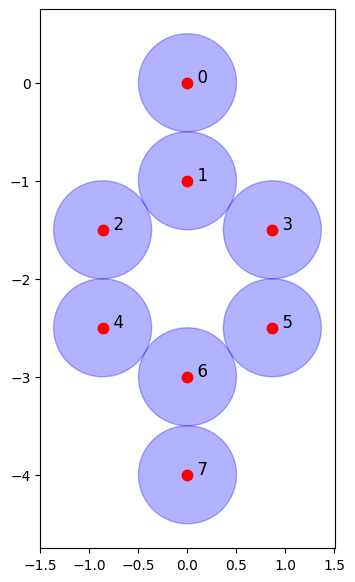

In [3]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [0, -3],
          [0, -4],
         ]
show_coords(coords)

In [3]:
neighbors = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
]

J1range = [-1/i for i in np.linspace(10, 1e2, 100)]

for J1 in J1range:
    
    _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1)

    _, _, _, configs_2 = QUBO(neighbors, J1=J1)

    configs_3 = [config for config in configs_1 if config in configs_2]
    print(f"len(configs_1), len(configs_2), len(configs_3) = {len(configs_1)}, {len(configs_2)}, {len(configs_3)}, J1={J1}")

len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.1
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.09166666666666667
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.08461538461538462
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07857142857142857
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07333333333333333
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.06875
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.06470588235294118
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 0, J1=-0.06111111111111111
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05789473684210526
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05500000000000001
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05238095238095238
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J

# Comparison of spectrum for J1 = -0.1, -0.061111, -0.02075, -0.015068, -0.01

In [8]:
def compare_spectrum(ryd_H, qubo_H, num_plots=1):
    
    if num_plots==2:
        
        fig, axes = plt.subplots(1, 2, figsize = (12, 6))

        axes[0].plot(ryd_H, '.')
        axes[1].plot(qubo_H, '.')
        axes[0].set_title(f"Spectrum of Rydberg Ham for J1={J1}")
        axes[1].set_title(f"Spectrum of QUBO for J1={J1}")
        axes[0].set_ylabel("energy")
        axes[0].set_xlabel("states")
        axes[1].set_xlabel("states")
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
    elif num_plots==1:
        plt.figure(figsize=(12,6))
        ryd_H_scaled = ryd_H / (max(ryd_H) - min(ryd_H)) * (max(qubo_H) - min(qubo_H))
        plt.plot(ryd_H_scaled, '.', label="Rydberg Ham")
        plt.plot(qubo_H, '.', label="QUBO")
        plt.title(f"Spectrum for J1={J1}")
        plt.xlabel("states")
        plt.xlabel("energy")
        plt.legend()
        plt.grid()
        plt.show()
        
    

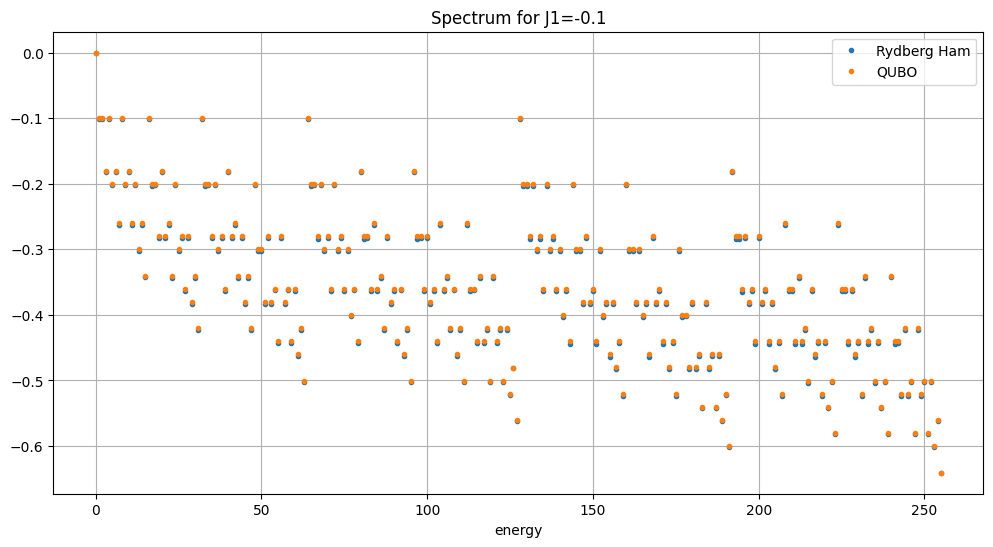

In [59]:
J1 = -0.1
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=1)

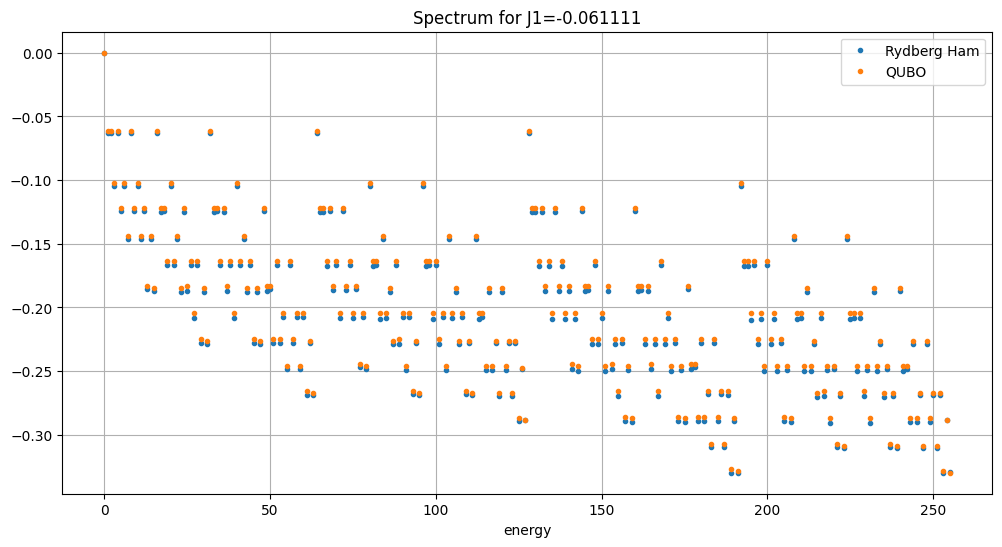

In [60]:
J1 = -0.061111
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=1)

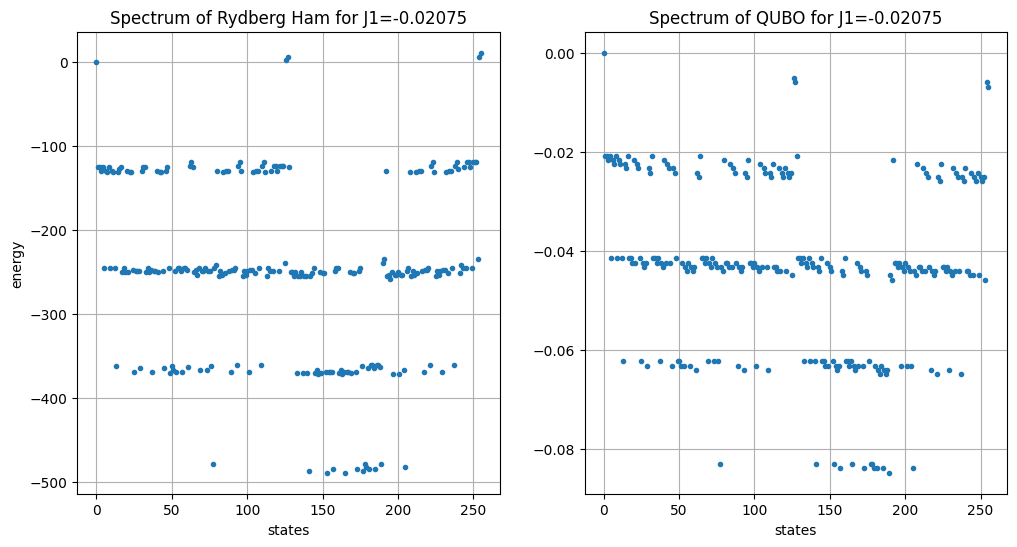

In [61]:
J1 = -0.02075
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

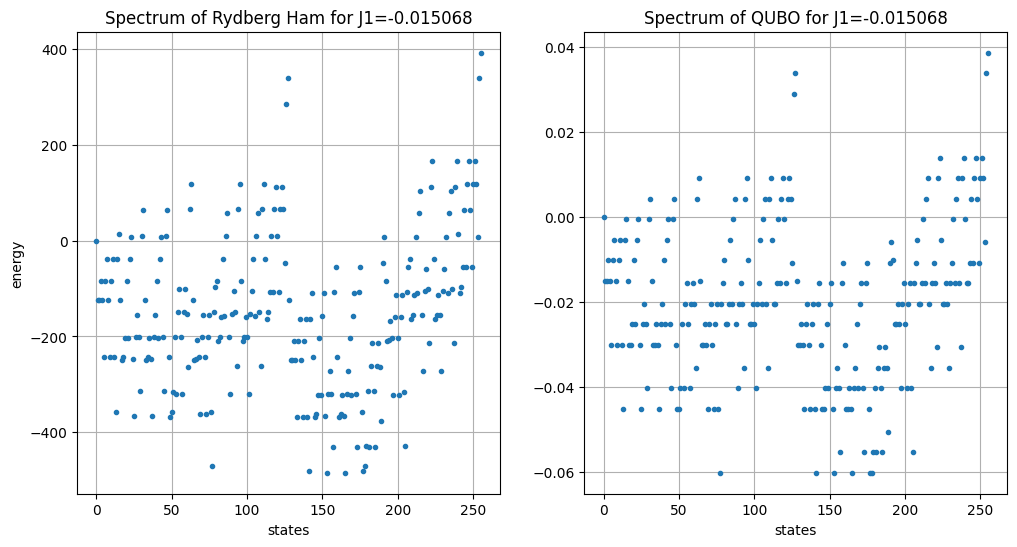

In [62]:
J1 = -0.015068
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

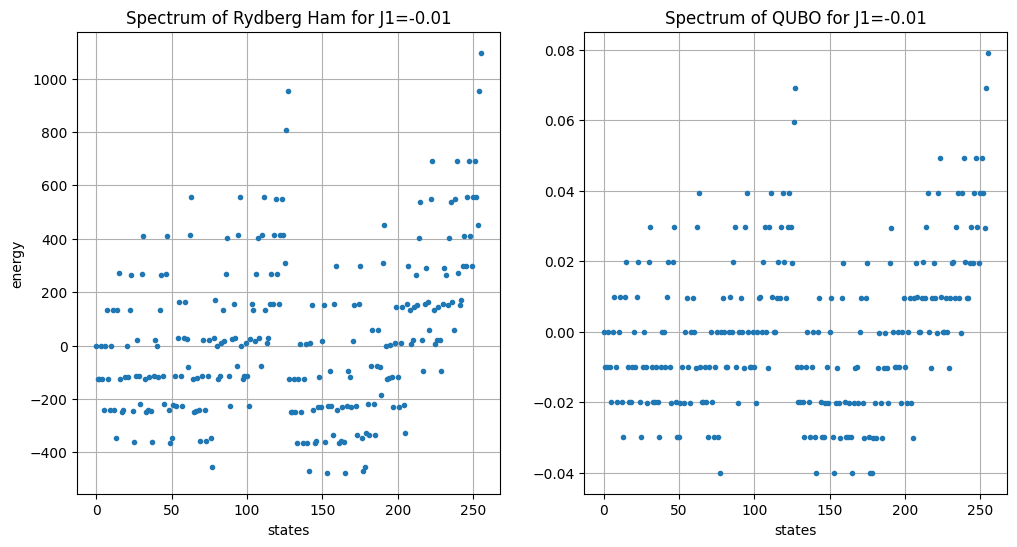

In [63]:
J1 = -0.01
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

# For 3x3 cells with 27 atoms

We scan J1 from -0.01 to -0.1, and found that 

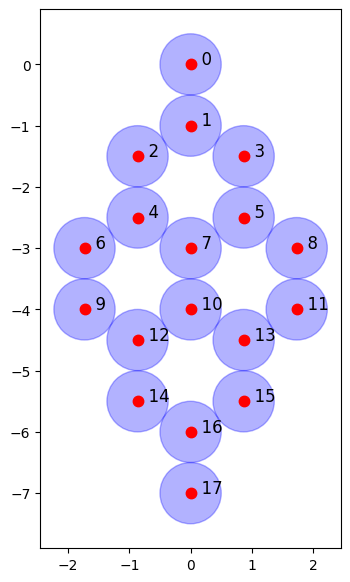

In [5]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [-np.sqrt(3), -3],
          [0, -3],
          [np.sqrt(3), -3],
          [-np.sqrt(3), -4],
          [0, -4],
          [np.sqrt(3), -4],
          [-np.sqrt(3)/2, -9/2],
          [np.sqrt(3)/2, -9/2],
          [-np.sqrt(3)/2, -11/2],
          [np.sqrt(3)/2, -11/2],                    
          [0, -6],
          [0, -7],
         ]
show_coords(coords)

In [6]:


neighbors = [
    (0, 1), 
    (1, 2), (1, 3), 
    (2, 4), (3, 5), 
    (4, 6), (4, 7), (5, 7), (5, 8),
    (6, 9), (7, 10), (8, 11),
    (9, 12), (10, 12), (10, 13), (11, 13),
    (12, 14), (13, 15),
    (14, 16), (15, 16),
    (16, 17)
]

J1range = [-1/i for i in np.linspace(10, 1e2, 100)]

for J1 in J1range:
    
    _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1)

    _, _, _, configs_2 = QUBO(neighbors, J1=J1)

    configs_3 = [config for config in configs_1 if config in configs_2]
    print(f"len(configs_1), len(configs_2), len(configs_3) = {len(configs_1)}, {len(configs_2)}, {len(configs_3)}, J1={J1}")

len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.1
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.09166666666666667
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.08461538461538462
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07857142857142857
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07333333333333333
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.06875
len(configs_1), len(configs_2), len(configs_3) = 2, 1, 0, J1=-0.06470588235294118
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 0, J1=-0.06111111111111111
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05789473684210526
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05500000000000001
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05238095238095238
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J

# Comparison of spectrum for J1 = -0.1, -0.061111, -0.02075, -0.015068, -0.01

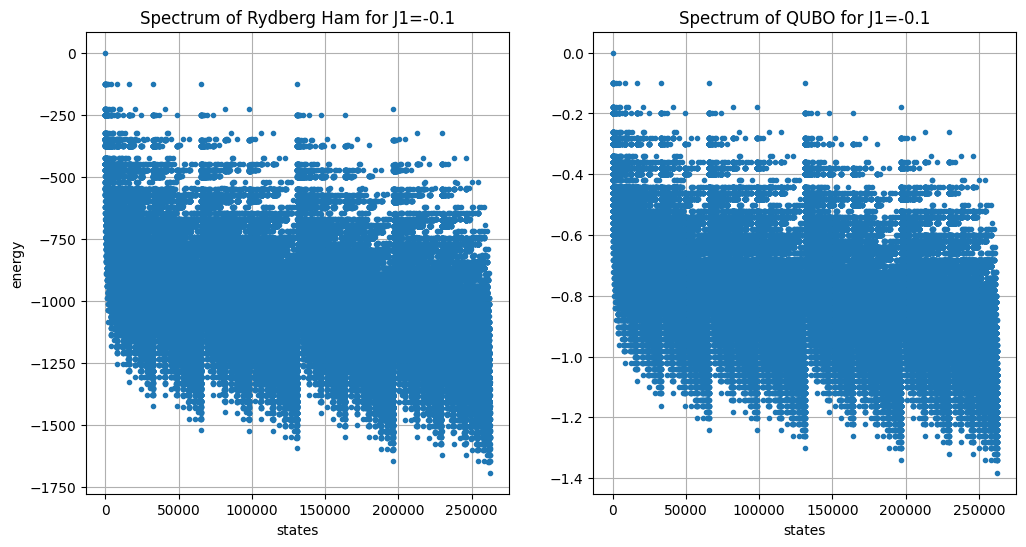

In [9]:
J1 = -0.1
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

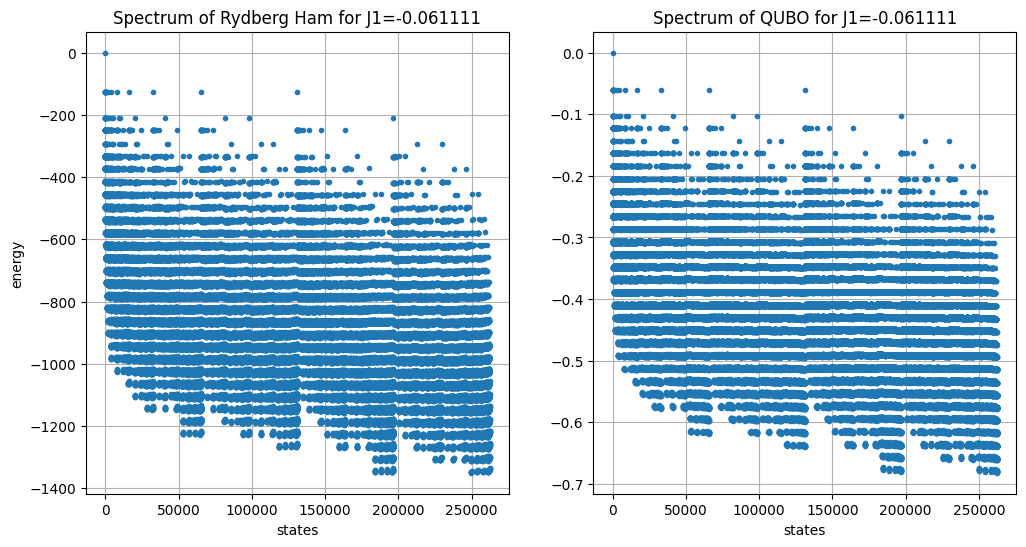

In [10]:
J1 = -0.061111
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

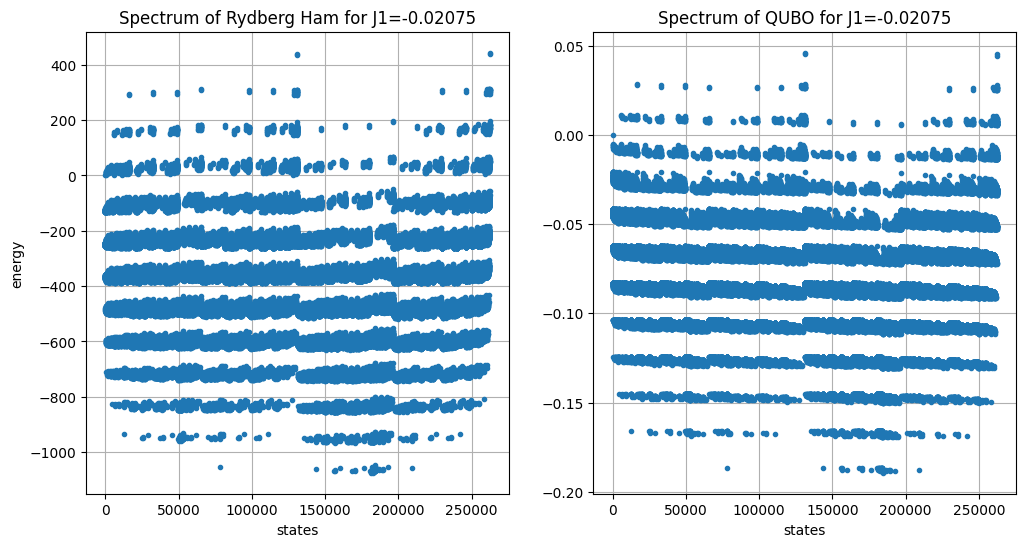

In [11]:
J1 = -0.02075
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

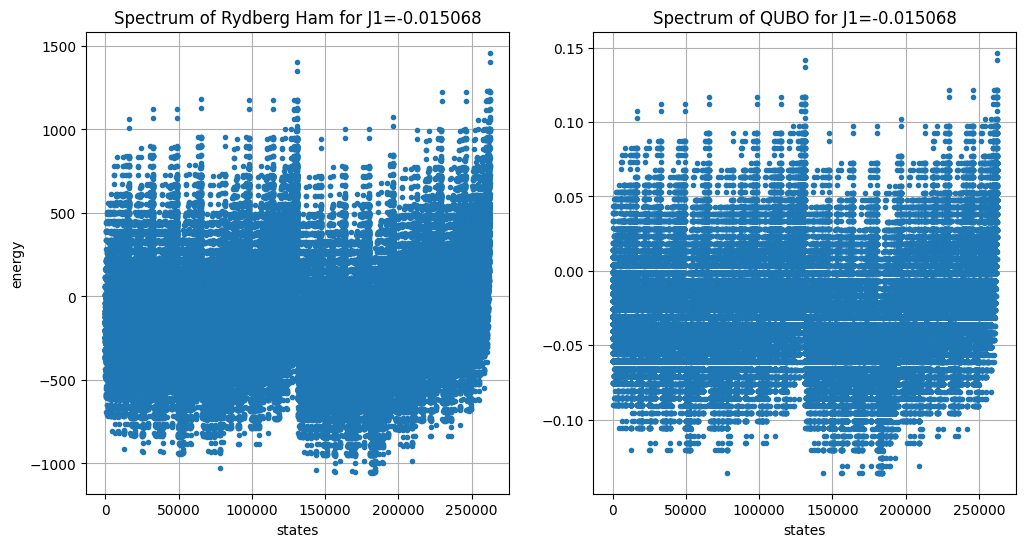

In [12]:
J1 = -0.015068
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)

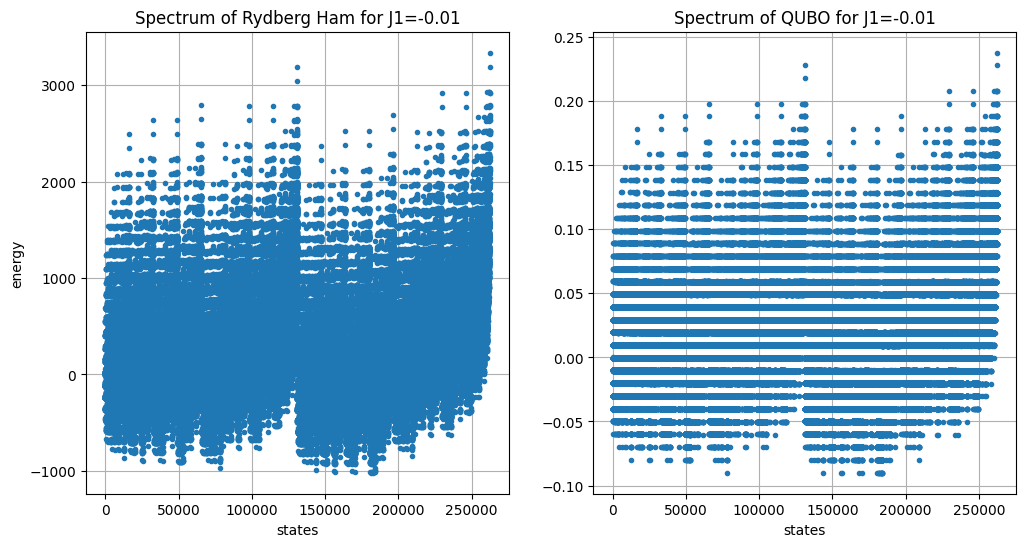

In [13]:
J1 = -0.01
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)